# Fraud Detection with Unsupervised Clustering 

Clustering methods used in this experiment:
* K-means Clustering
* Hierarchical Clustering
* Gaussian Mixture Model~(GMM)
* Bayesian Gaussian Mixture~(BGM)

In [1]:
import time

# get the start time
st = time.time()

In [2]:
'''
Import Libraries
'''

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import QuantileTransformer
from sklearn.mixture import BayesianGaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import IsolationForest

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture as GMM
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage, inconsistent, fcluster
from sklearn import metrics
import matplotlib.cm as cm
from scipy import stats
import matplotlib as mpl


from IPython.core.interactiveshell import InteractiveShell

mpl.rcParams.update(mpl.rcParamsDefault)
InteractiveShell.ast_node_interactivity = "all"

warnings.filterwarnings('ignore')

In [3]:
# # only when you are running on Google Colab
# from google.colab import drive
# import pandas as pd

# # Mount Google Drive
# drive.mount('/content/drive')

## Helper Functions

### Data Preprocessing

In [4]:
def read_df(csv_path):
    df = pd.read_csv(csv_path, sep=';')
    return df

In [5]:
# feature selection
def select_features(csv_path, out_path):
    df = read_df(csv_path)
    # drop features as based on the feature analysis
    df_dropped = df.drop(['Prix_verres', 'PEC_CRE', 'cor_sphere_VD', 'cor_cylindre_VD', 'cor_addition_VD', 'Pourcent_remise_verre', 'taux_non_ventes', 'PEC_ACC', 'nb_lignes_PEC'], axis = 1)

    # df_dropped = df.drop([ 'Prix_verres', 'PEC_CRE', 'cor_sphere_VD', 'cor_cylindre_VD', 'cor_addition_VD', 'Pourcent_remise_monture', 'Pourcent_remise_verre', 'taux_non_ventes', 'PEC_ACC', 'nb_lignes_PEC'], axis = 1)
    # df_dropped = df.drop(['PEC_REF', 'PEC_CRE', 'cor_cylindre_VG', 'cor_cylindre_VD', 'age_moyen', 'Pourcent_remise_verre', 'taux_non_ventes', 'PEC_ACC', 'nb_lignes_PEC'], axis = 1)
    df_dropped.to_csv(out_path, index = False)
    return df_dropped

### Visualisation

In [6]:
# function to check data skewness
def check_skew(df, column):
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

In [7]:
# visualize the data distribution after fixing skewness
def visulalise_skewed_data(df):
    plt.figure(figsize=(20, 10))

    for i in range(26):
        plt.subplot(5, 6, i+1)
        check_skew(df, cols[i])

    plt.tight_layout()

In [8]:
def generate_tsne_scatter_plot(df, clustering, k=1):
    tsne = TSNE(random_state = 42)
    X_embedded_quant = tsne.fit_transform(df)

    # visualize original data after scaling and normalizing 
    sns.set(rc={'figure.figsize':(12,8)})
    palette = sns.color_palette("bright", k)
    if clustering == True:
        sns.scatterplot(x=X_embedded_quant[:,0], y=X_embedded_quant[:,1], hue=df['cluster_id'], legend='full', palette = palette)
    else:
        sns.scatterplot(x=X_embedded_quant[:,0], y=X_embedded_quant[:,1], color='black')
    plt.show()

In [9]:
def generate_dendrogram(df, line, cut_n=1):
    plt.figure(figsize=(10, 7))  
    plt.title("Dendrograms")  
    dend = dendrogram(linkage(df, method='ward'))
    if line == True:
        plt.axhline(y=cut_n, color='r', linestyle='--')
        
    plt.show()


In [10]:
def generate_bic(df):
    n_components = np.arange(1, 10)
    models = [GMM(n, covariance_type='full', random_state=42).fit(df)
              for n in n_components]

    plt.plot(n_components, [m.bic(df) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(df) for m in models], label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.show()
    

### Models

In [11]:
# use Elbow method to find best number of clusters
def no_of_clusters_kmeans(df):
    kmeans = KMeans()
    elbow = KElbowVisualizer(kmeans, k=(1, 20))
    elbow.fit(df)
    elbow.show(block=True)

    print('\nBest number of clusters: %d'%elbow.elbow_value_) # output the best number of clusters
    
    return elbow.elbow_value_

In [12]:
def no_of_pca_comp(pca):
    plt.plot(pca.explained_variance_ratio_.cumsum())
    plt.xlabel('Principal component')
    plt.xlim(0,15)
    plt.ylabel('Explained variance ratio')
    plt.title('Cummulative explained variance ratio')
    plt.grid(True, alpha = 0.4)
    plt.tight_layout()
    plt.show()

In [13]:
def no_of_clusters_hier(df):
    # Perform hierarchical clustering
    linked = linkage(df, method='ward')  # You can choose different linkage methods based on your requirements

    # Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(linked)
    plt.title('Dendrogram')
    plt.xlabel('Data Points')
    plt.ylabel('Distance')
    plt.show()

    # Set a height or distance threshold to determine the number of clusters
    threshold = 10  # Adjust this threshold based on the dendrogram plot

    # Obtain cluster assignments based on the threshold
    clusters = fcluster(linked, threshold, criterion='distance')

    # Get the number of clusters
    num_clusters = len(np.unique(clusters))

    print("Number of clusters:", num_clusters)
    return num_clusters

In [14]:
def no_of_clusters_gm(data, min_clusters, max_clusters, criterion='aic'):
    n_clusters_range = range(min_clusters, max_clusters+1)
    criteria = []

    for n_clusters in n_clusters_range:
        gmm = GaussianMixture(n_components=n_clusters)
        gmm.fit(data)
        
        if criterion == 'aic':
            criteria.append(gmm.aic(data))
        elif criterion == 'bic':
            criteria.append(gmm.bic(data))
        else:
            raise ValueError("Invalid criterion. Choose 'aic' or 'bic'.")
    
    optimal_clusters = n_clusters_range[np.argmin(criteria)]
    return optimal_clusters

In [15]:
def scale_features(df):
    qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
    df_ = df.drop(['ref_PS'], axis=1)
    cols = df_.columns.tolist()
    df_ = qt.fit_transform(df_)

    df_ = pd.DataFrame(df_)
    df_.columns = cols
    
    # centering data
    df_ = df_ - df_.mean()

    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    df_[:] = scaler.fit_transform(df_[:])
    return df_

In [16]:
# Clustering
def generate_clusters(df_scaled, k, algo):

    if algo == 'k-means':
        model_ = KMeans(n_clusters = k,
                              init = 'k-means++',
                              max_iter = 300,
                              n_init = 10,
                              random_state = 42)
        
    if algo == 'hier':     
        model_ = AgglomerativeClustering(n_clusters = k,
                                         affinity = 'euclidean', 
                                         linkage = 'ward') 
        
    if algo == 'GMM':
        model_ = GMM(n_components = k, 
                       random_state = 42, 
                       covariance_type = 'full', 
                       n_init = 20)
    
    if algo == 'BGM':
        model_ = BayesianGaussianMixture(n_components = k, 
                                      random_state=42)
    
    if algo == 'iso':
        model_ = IsolationForest(contamination=0.02) # the expected percentage of anomalies in the dataset (200/12000)

    model_.fit(df_scaled)
    cluster_labels = model_.fit_predict(df_scaled)

    print('------- '+algo+' -------')
    sil, dav = generate_scores(df_scaled, cluster_labels)
    print('')
    df_scaled_ = df_scaled.copy()
    df_scaled_['cluster_id'] = cluster_labels

    return df_scaled_

### Evaluation

In [17]:
# Model evaluation metrics
def generate_scores(df, labels_):
    sil_score = metrics.silhouette_score(df, labels_)
    dav_score = metrics.davies_bouldin_score(df, labels_)
    
    print("Silhouette Coefficient: %0.3f" % sil_score)
    print("Davies-Bouldin Score: %0.3f" % dav_score)
    
    return sil_score, dav_score

In [67]:
# Evaulate % of fraud in clusters
def fraud_table(df, target_df):
    df_ = df.copy()
    df_['fraud'] = [True if x in target_df['ref_PS'].tolist() else False for x in df_['ref_PS'].tolist()]

    res_table = df_.groupby(['cluster_id', 'fraud']).size().reset_index(name='Count')
    res_table['in-group pct'] = res_table['Count'] / res_table.groupby('cluster_id')['Count'].transform('sum')
    
    best_pct = res_table[res_table['fraud']==True]['in-group pct'].max()
    best_idx = res_table[res_table['fraud']==True]['in-group pct'].idxmax()
    best_cluster = res_table.iloc[best_idx]['cluster_id']
    
    return res_table, best_cluster, best_pct

In [19]:
# Feature Importance
def clusterting_feature_importance (df, cluster_col):
    """
    get the dataframe with the cluster column, and check, per cluster the minimal STD per column range
    those are the best features
    """
    scores = pd.DataFrame()
    df0 = df.copy()
    df0 = df.select_dtypes(include=np.number)

    for i in df0[cluster_col].unique():
        df2 = df0[df0[cluster_col] == i]
        df2.drop(cluster_col,axis=1, inplace=True)
        #df2 = df.select_dtypes(include=np.number)
        scores[i] = df2.std() / (df2.max() - df2.min())
    scores['mean'] = scores.mean(axis = 1)

    scores = 1 - scores

    return scores

### Clustering

### Read csv to df

In [20]:
# load data

# Behavioral description of opticians - Dataset 1
'''
In the first dataset, each line concerns a sale of glasses with information on the price, the type of correction,
the beneficiary (patient) or the optician (seller).
'''
sales_info = 'dataset/optical_care_transaction_opticiens.csv'
# sales_info = '/content/drive/MyDrive/Reach-Incubator-Challenge/reach-challenge-master/dataset/optical_care_transaction_opticiens.csv' # only when you are running on Google Colab

# Historical data of reimbursement requests from opticians to insurance companies - Dataset 2
'''
In the second dataset, each line groups together the information of a single optician
(total number of glasses sold, average selling price of glasses, etc.).
The second dataset describes the behaviour of each optician and it is important to
understand that it is calculated via an aggregation of data from the first dataset.
'''
single_optician_data = 'dataset/historical_data.csv'
single_optician_meta_data = 'dataset/historical_data_attribute_description.xlsx'


# ID of proven fraudulent opticians - Dataset 3
'''
The third dataset is a list of opticians who are already known fraudsters.
'''
fraudulent_opticians = 'dataset/almerys_fraudulent_optician_id.csv'

'\nIn the first dataset, each line concerns a sale of glasses with information on the price, the type of correction,\nthe beneficiary (patient) or the optician (seller).\n'

'\nIn the second dataset, each line groups together the information of a single optician\n(total number of glasses sold, average selling price of glasses, etc.).\nThe second dataset describes the behaviour of each optician and it is important to\nunderstand that it is calculated via an aggregation of data from the first dataset.\n'

'\nThe third dataset is a list of opticians who are already known fraudsters.\n'

In [21]:
# !ls /content/drive/MyDrive/Reach-Incubator-Challenge/reach-challenge-master/dataset/

In [22]:
df = pd.read_csv(sales_info, sep = ';')
df

ref_PS  nb_lignes_PEC  dep_identique  dep_limit  \
0      8c47fdd7c69650b             53          96.23       1.89   
1      89bf4429f3ebda1             31         100.00       0.00   
2      5076215e2ee1797             22          95.45       4.55   
3      3a771e3f5cbc3b2             41          97.56       0.00   
4      ced6f62ac55fd34              4          50.00       0.00   
...                ...            ...            ...        ...   
12611  c335633c0fbe713             76          75.00      25.00   
12612  72373e7fa1ab691             20          90.00      10.00   
12613  997171895d121ff             35          88.57       8.57   
12614  8759d1c2aa42bb8             60          93.33       6.67   
12615  ee3e25bff6e919f             57          87.72       1.75   

       dep_non_limit  PEC_CRE  PEC_ANN  PEC_ACC  PEC_FAC  PEC_REF  ...  \
0               1.89    30.19     3.77     0.00    62.26     3.77  ...   
1               0.00    19.35    22.58     0.00    51.61     6.45  ...   
2               0.00     4.55    13.64    13.64    68.18     0.00  ...   
3               2.44    12.20     0.00     4.88    82.93     0.00  ...   
4              50.00     0.00    25.00     0.00    75.00     0.00  ...   
...              ...      ...      ...      ...      ...      ...  ...   
12611           0.00     0.00    14.47     7.89    40.79    36.84  ...   
12612           0.00    20.00     5.00    20.00    50.00     5.00  ...   
12613           2.86     2.86    28.57     0.00    34.29    34.29  ...   
12614           0.00     0.00    25.00     3.33    43.33    28.33  ...   
12615          10.53     3.51    28.07     7.02    59.65     1.75  ...   

       cor_sphere_VD  cor_cylindre_VD  cor_addition_VD  cor_sphere_VG  \
0          -0.188679         0.056604         0.226415      -0.301887   
1           0.129032         0.000000         0.129032       0.000000   
2          -0.227273         0.318182         0.181818      -0.272727   
3          -0.024390         0.000000         0.048780       0.000000   
4          -0.500000         0.000000         0.000000      -0.500000   
...              ...              ...              ...            ...   
12611      -0.881579         0.723684         0.934211      -0.684211   
12612       0.100000         0.000000         0.550000       0.000000   
12613      -0.200000         0.228571         0.028571      -0.228571   
12614      -1.033333         0.483333         0.933333      -1.066667   
12615      -0.122807         0.175439         0.228070      -0.035088   

       cor_cylindre_VG  cor_addition_VG  facteur_correction  age_moyen  \
0             0.056604         0.226415            1.056604  45.396226   
1             0.096774         0.193548            0.548387  49.096774   
2             0.227273         0.181818            2.318182  34.863636   
3             0.000000         0.048780            0.365854  31.829268   
4             0.000000         0.000000            1.000000  43.750000   
...                ...              ...                 ...        ...   
12611         0.526316         0.934211            6.657895  41.960526   
12612         0.000000         0.550000            2.600000  53.600000   
12613         0.542857         0.028571            3.257143  32.857143   
12614         0.250000         0.933333            5.900000  48.016667   
12615         0.105263         0.228070            1.842105  36.771930   

       nb_prescripteurs  nb_PEC_par_prescripteurs  
0                    24                      2.21  
1                    11                      2.82  
2                    11                      2.00  
3                     8                      5.12  
4                     3                      1.33  
...                 ...                       ...  
12611                18                      4.22  
12612                 9                      2.22  
12613                11                      3.18  
12614                 6             

In [23]:
select_features(sales_info, 'results/selected_features.csv')

ref_PS  dep_identique  dep_limit  dep_non_limit  PEC_ANN  \
0      8c47fdd7c69650b          96.23       1.89           1.89     3.77   
1      89bf4429f3ebda1         100.00       0.00           0.00    22.58   
2      5076215e2ee1797          95.45       4.55           0.00    13.64   
3      3a771e3f5cbc3b2          97.56       0.00           2.44     0.00   
4      ced6f62ac55fd34          50.00       0.00          50.00    25.00   
...                ...            ...        ...            ...      ...   
12611  c335633c0fbe713          75.00      25.00           0.00    14.47   
12612  72373e7fa1ab691          90.00      10.00           0.00     5.00   
12613  997171895d121ff          88.57       8.57           2.86    28.57   
12614  8759d1c2aa42bb8          93.33       6.67           0.00    25.00   
12615  ee3e25bff6e919f          87.72       1.75          10.53    28.07   

       PEC_FAC  PEC_REF  Prix_monture  Prix_equipement  \
0        62.26     3.77     82.264151       308.792453   
1        51.61     6.45    111.870968       362.580645   
2        68.18     0.00    220.454545       530.727273   
3        82.93     0.00    211.707317       517.512195   
4        75.00     0.00    201.250000       522.250000   
...        ...      ...           ...              ...   
12611    40.79    36.84    143.973684       586.184211   
12612    50.00     5.00    119.700000       564.100000   
12613    34.29    34.29    137.885714       376.942857   
12614    43.33    28.33    120.933333       500.700000   
12615    59.65     1.75    170.438596       397.912281   

       Pourcent_remise_monture  Pourcent_remise_total  cor_sphere_VG  \
0                     0.000000               0.000000      -0.301887   
1                    16.118800               7.927046       0.000000   
2                     0.000000               0.000000      -0.272727   
3                     0.000000               0.000000       0.000000   
4                     0.000000               0.000000      -0.500000   
...                        ...                    ...            ...   
12611                 0.813380               0.565657      -0.684211   
12612                20.927318              18.356674       0.000000   
12613                 0.000000               0.454787      -0.228571   
12614                 4.561742               2.819386      -1.066667   
12615                10.159547              11.882192      -0.035088   

       cor_cylindre_VG  cor_addition_VG  facteur_correction  age_moyen  \
0             0.056604         0.226415            1.056604  45.396226   
1             0.096774         0.193548            0.548387  49.096774   
2             0.227273         0.181818            2.318182  34.863636   
3             0.000000         0.048780            0.365854  31.829268   
4             0.000000         0.000000            1.000000  43.750000   
...                ...              ...                 ...        ...   
12611         0.526316         0.934211            6.657895  41.960526   
12612         0.000000         0.550000            2.600000  53.600000   
12613         0.542857         0.028571            3.257143  32.857143   
12614         0.250000         0.933333            5.900000  48.016667   
12615         0.105263         0.228070            1.842105  36.771930   

       nb_prescripteurs  nb_PEC_par_prescripteurs  
0                    24                      2.21  
1                    11                      2.82  
2                    11                      2.00  
3                     8                      5.12  
4                     3                      1.33  
...                 ...                       ...  
12611                18                      4.22  
12612                 9                      2.22  
12613                11                      3.18  
12614                 6                     10.00  
12615                28                      2.04  

[12616 rows x 18 columns]

### Data Prep

In [24]:
df = read_df(sales_info)
selected_df = pd.read_csv('results/selected_features.csv')

In [25]:
scaled_df = scale_features(df)
scaled_selected_df = scale_features(selected_df)
# scaled_pca_df = scale_features(pca_df)


In [26]:
df_norm_kmeans = pd.read_csv('normalized_selected.csv')

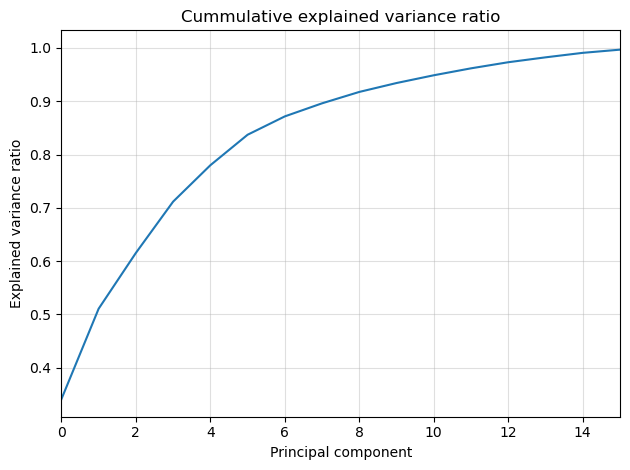

In [27]:
pca = PCA(random_state = 42)
pca_df = pd.DataFrame(pca.fit_transform(scaled_selected_df))
# get best pc numbers
# as shown in below figure, 8 PCA components explain over 90% of the variance with a easy to see elbow
no_of_pca_comp(pca)

In [28]:
pca_ = PCA(n_components=6, random_state = 42)
scaled_pca_df = pd.DataFrame(pca_.fit_transform(scaled_selected_df))

In [29]:
# Correlations for PCA Components. 
loadings = pca_.components_.T * np.sqrt(pca_.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC0','PC1', 'PC2', 'PC3', 'PC4', 'PC5'], 
                              index=pca_df.columns.tolist())
loading_matrix.to_csv('results/clusters/pca_correlations.csv', index = False)


In [30]:
loading_matrix

PC0       PC1       PC2       PC3       PC4       PC5
0   0.147971 -0.168743 -0.040319  0.011579 -0.000716 -0.005192
1  -0.144062  0.181092  0.036670 -0.137748 -0.002347  0.012230
2  -0.172298  0.099696  0.020377  0.205260  0.007329 -0.005774
3  -0.120640 -0.033250 -0.036559 -0.013306 -0.149262 -0.101332
4   0.062681  0.030683  0.034174  0.003617  0.071970 -0.009629
5  -0.171312 -0.060160 -0.102944 -0.003878 -0.035810  0.145014
6   0.006350  0.014029 -0.020043  0.007169 -0.000674 -0.007520
7  -0.001701  0.005533 -0.020232  0.003703  0.009874 -0.009459
8  -0.151176 -0.123069  0.134648 -0.012753  0.010215  0.005830
9  -0.141794 -0.117821  0.131515 -0.014381  0.010877  0.005687
10  0.010920 -0.004010  0.006272 -0.001761 -0.006268  0.005257
11 -0.148485 -0.042415 -0.084456 -0.022678  0.083078 -0.054827
12 -0.126719 -0.038143 -0.067509 -0.018755  0.069206 -0.040694
13 -0.094530 -0.028554 -0.057147 -0.015414  0.057199 -0.030563
14  0.004852 -0.008364  0.007737  0.000210  0.012891 -0.000910
15 -0.082914 -0.006632 -0.012149  0.004114 -0.004526 -0.006060
16 -0.079727 -0.028936 -0.025808 -0.005821 -0.020427  0.003339

### Plots before clustering

In [31]:
# #[ToDO:check this!]
# generate_tsne_scatter_plot(df, False)
# generate_tsne_scatter_plot(pca_df, False)
# generate_tsne_scatter_plot(selected_df, False)
# generate_tsne_scatter_plot(selected_pca_df, False)

In [32]:
# scaled_pca_df_kmeans = scaled_pca_df.copy()
# scaled_pca_df_hier = scaled_pca_df.copy()
# scaled_pca_df_gmm = scaled_pca_df.copy()
# scaled_pca_df_bgm = scaled_pca_df.copy()

# scaled_selected_df_kmeans = scaled_selected_df.copy()
# scaled_selected_df_hier = scaled_selected_df.copy()
# scaled_selected_df_gmm = scaled_selected_df.copy()
# scaled_selected_df_bgm = scaled_selected_df.copy()

# scaled_pca_df_kmeans = scaled_pca_df.copy()
# scaled_pca_df_hier = scaled_pca_df.copy()
# scaled_pca_df_gmm = scaled_pca_df.copy()
# scaled_pca_df_bgm = scaled_pca_df.copy()

## Cluster Modelling

In [33]:
# selected_df = df.drop(['ref_PS', 'Prix_verres', 'PEC_CRE', 'cor_sphere_VD', 'cor_cylindre_VD', 'cor_addition_VD', 'Pourcent_remise_verre', 'taux_non_ventes', 'PEC_ACC', 'nb_lignes_PEC'], axis = 1)
# scaled_selected_df = pd.read_csv('normalized_selected.csv')

# # reading in normalized data for K-means 
# scaled_pca_df = pd.read_csv('normalized_selected.csv')

# # creating normalized data once again 
# pca_final_norm2 = PCA(n_components=6, random_state = 42)
# scaled_pca_df = pd.DataFrame(pca_final_norm2.fit_transform(scaled_pca_df))

### K-Means

#### Elbow - Get k value

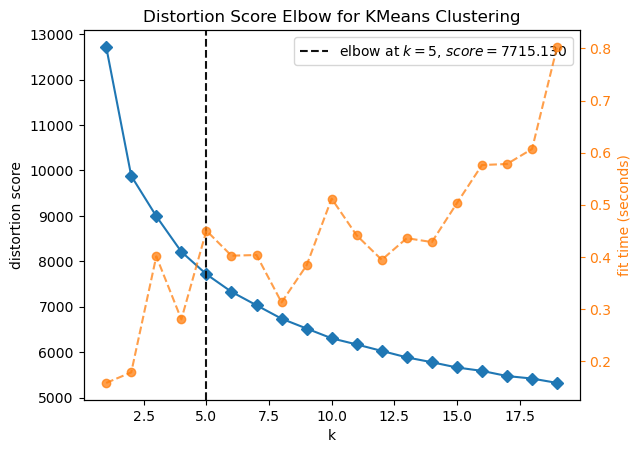


Best number of clusters: 5


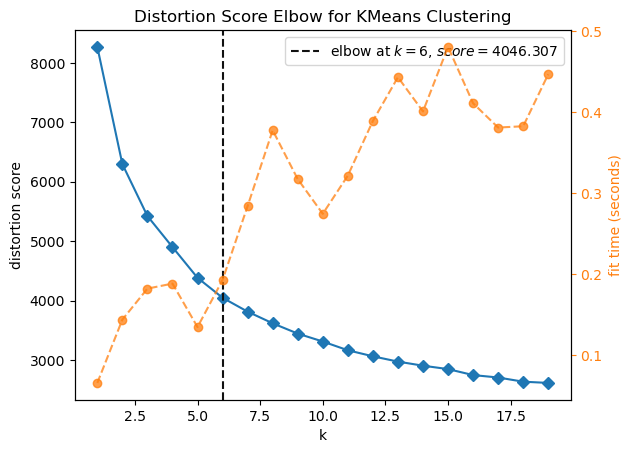


Best number of clusters: 6


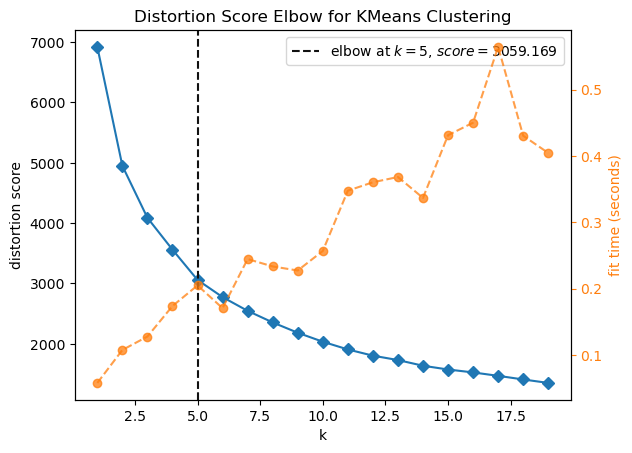


Best number of clusters: 5


In [34]:
k_ = no_of_clusters_kmeans(scaled_df)
k_selected = no_of_clusters_kmeans(scaled_selected_df)
k_pca = no_of_clusters_kmeans(scaled_pca_df)

#### Clustering

In [35]:
# all data
k_means_ = generate_clusters(scaled_df, k_, 'k-means')
# selected data
k_means_selected = generate_clusters(scaled_selected_df, 6, 'k-means')
# PCA data
pca_df = selected_df.copy()
k_means_pca = generate_clusters(scaled_pca_df, 5, 'k-means')

------- k-means -------
Silhouette Coefficient: 0.173
Davies-Bouldin Score: 1.994

------- k-means -------
Silhouette Coefficient: 0.247
Davies-Bouldin Score: 1.506

------- k-means -------
Silhouette Coefficient: 0.317
Davies-Bouldin Score: 1.287



#### Visualisation - TSNE before clustering

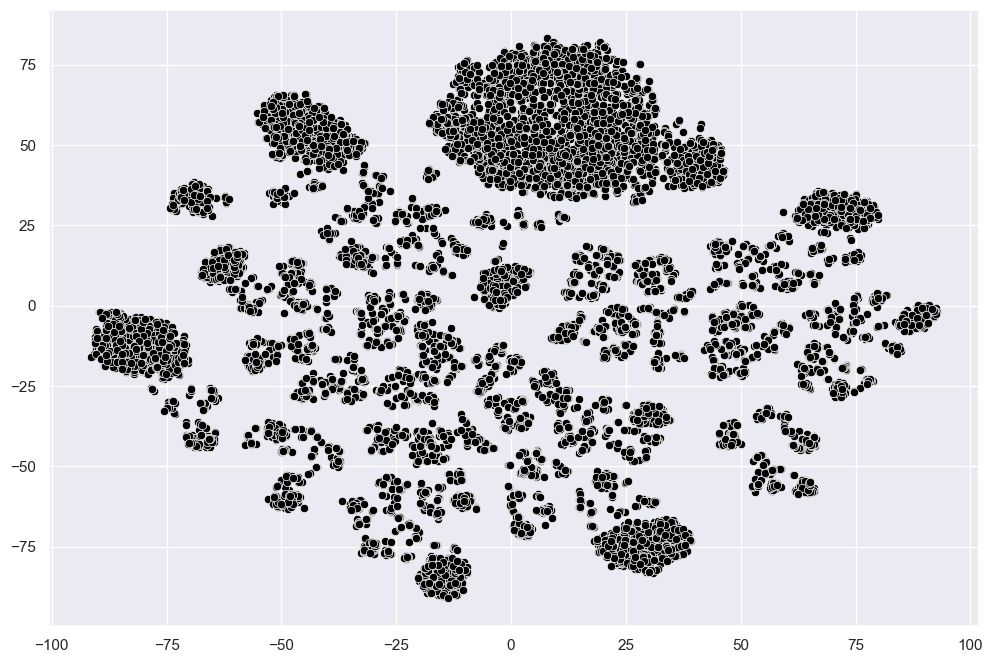

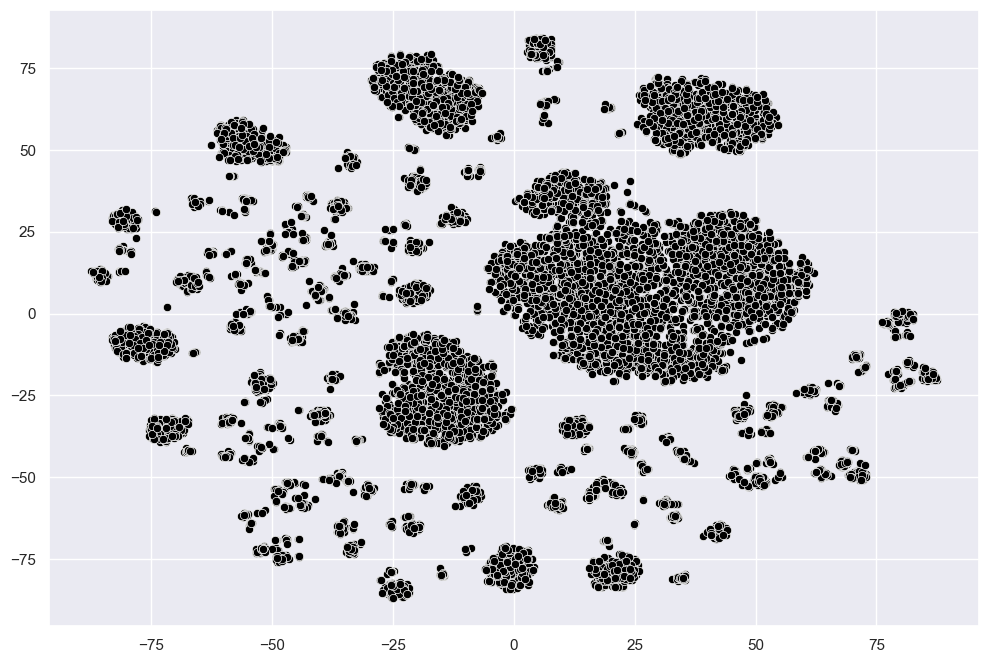

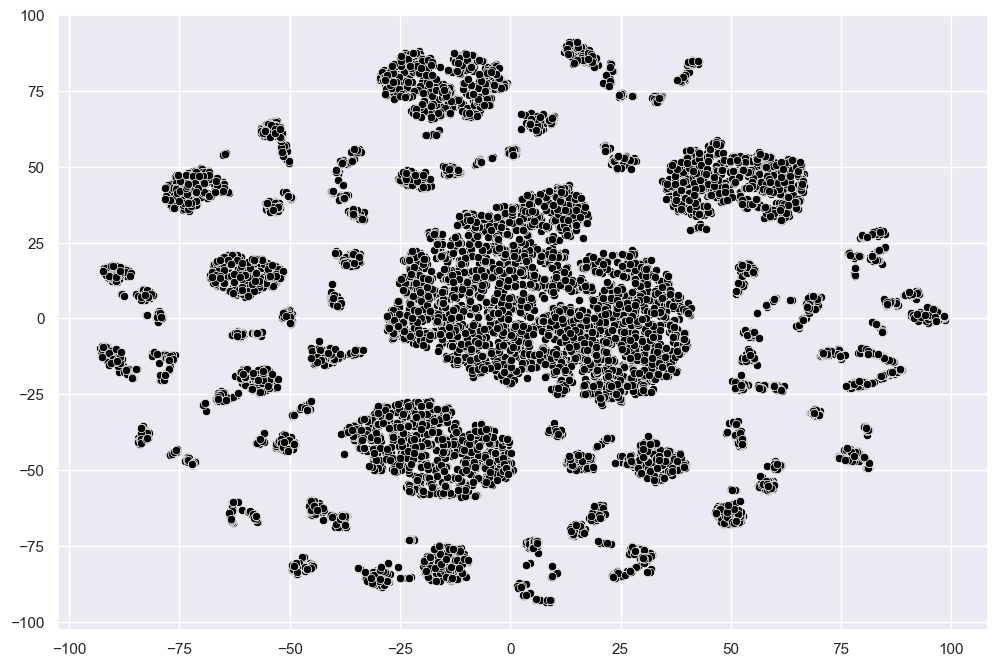

In [36]:
generate_tsne_scatter_plot(scaled_df, False)
generate_tsne_scatter_plot(scaled_selected_df, False)
generate_tsne_scatter_plot(scaled_pca_df, False)


#### Visualisation - TSNE after clustering

In [37]:
scaled_df

nb_lignes_PEC  dep_identique  dep_limit  dep_non_limit   PEC_CRE  \
0           0.525511       0.545160   0.479209       0.508214  0.642520   
1           0.481303       1.000000   0.000000       0.000000  0.582250   
2           0.455109       0.538266   0.500121       0.000000  0.466392   
3           0.503741       0.556113   0.000000       0.516366  0.533865   
4           0.347639       0.367472   0.000000       0.747674  0.000000   
...              ...            ...        ...            ...       ...   
12611       0.557261       0.436719   0.587595       0.000000  0.000000   
12612       0.448404       0.500965   0.532840       0.000000  0.586324   
12613       0.490938       0.492391   0.525511       0.522648  0.446724   
12614       0.535539       0.522524   0.514777       0.000000  0.000000   
12615       0.531309       0.488734   0.478120       0.604263  0.454140   

        PEC_ANN   PEC_ACC   PEC_FAC   PEC_REF  taux_non_ventes  ...  \
0      0.445344  0.000000  0.488025  0.476234         0.536160  ...   
1      0.642591  0.000000  0.434677  0.502534         0.588697  ...   
2      0.563132  0.644802  0.519189  0.000000         0.429968  ...   
3      0.000000  0.559582  0.596763  0.000000         0.396368  ...   
4      0.658133  0.000000  0.555257  0.000000         0.467032  ...   
...         ...       ...       ...       ...              ...  ...   
12611  0.572466  0.600437  0.374531  0.649468         0.608786  ...   
12612  0.461472  0.676102  0.425487  0.489361         0.494326  ...   
12613  0.678748  0.000000  0.344221  0.641243         0.680261  ...   
12614  0.658133  0.531055  0.388494  0.616801         0.618924  ...   
12615  0.675818  0.589920  0.473362  0.456450         0.512827  ...   

       cor_sphere_VD  cor_cylindre_VD  cor_addition_VD  cor_sphere_VG  \
0           0.463206         0.450206         0.462478       0.436189   
1           0.573539         0.000000         0.431220       0.521657   
2           0.453760         0.596364         0.448682       0.442451   
3           0.504466         0.000000         0.405017       0.521657   
4           0.399146         0.000000         0.000000       0.397670   
...              ...              ...              ...            ...   
12611       0.342792         0.710866         0.618306       0.367247   
12612       0.564334         0.000000         0.544622       0.521657   
12613       0.460162         0.553226         0.401192       0.452380   
12614       0.323249         0.658371         0.617894       0.319757   
12615       0.479285         0.523430         0.463036       0.500747   

       cor_cylindre_VG  cor_addition_VG  facteur_correction  age_moyen  \
0             0.447985         0.462516            0.422236   0.498181   
1             0.474364         0.452401            0.388158   0.541061   
2             0.549932         0.448821            0.492149   0.366282   
3             0.000000         0.405017            0.375774   0.334403   
4             0.000000         0.000000            0.418098   0.478361   
...                ...              ...                 ...        ...   
12611         0.670591         0.618463            0.694316   0.455589   
12612         0.000000         0.544622            0.505915   0.590389   
12613         0.674258         0.401105            0.534532   0.345341   
12614         0.561495         0.618242            0.660031   0.528636   
12615         0.480442         0.463036            0.467029   0.387854   

       nb_prescripteurs  nb_PEC_par_prescripteurs  
0              0.576814                  0.461864  
1              0.475362                  0.505432  
2              0.475362                  0.442451  
3              0.441147                  0.604031  
4              0.358842                  0.361276  
...                 ...                       ...  
12611          0.536704                  0.573216  
12612          0.453081                  0.462516  
12613          0.47

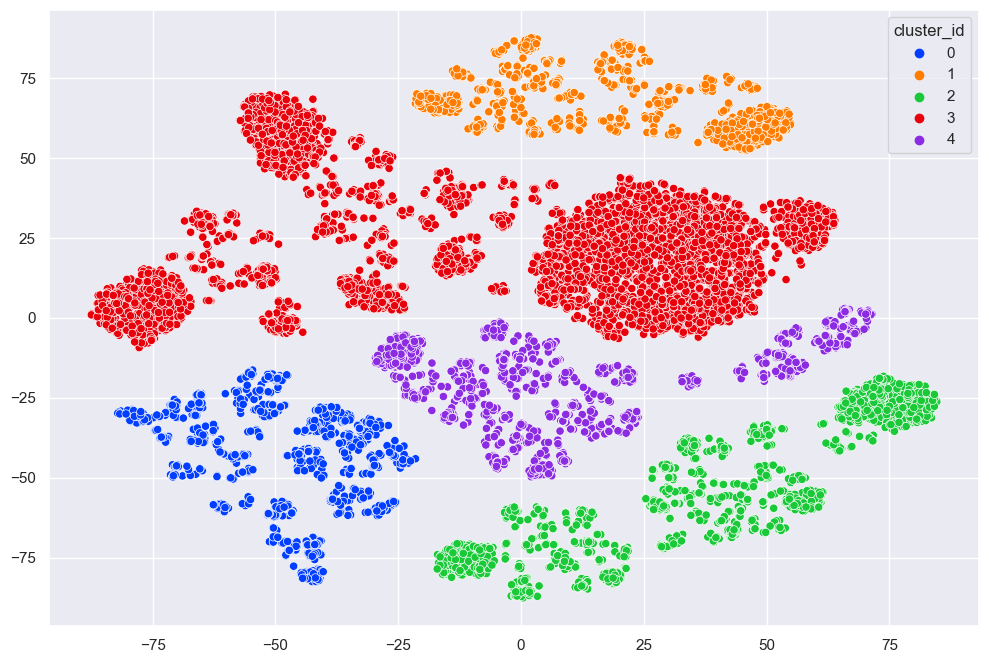

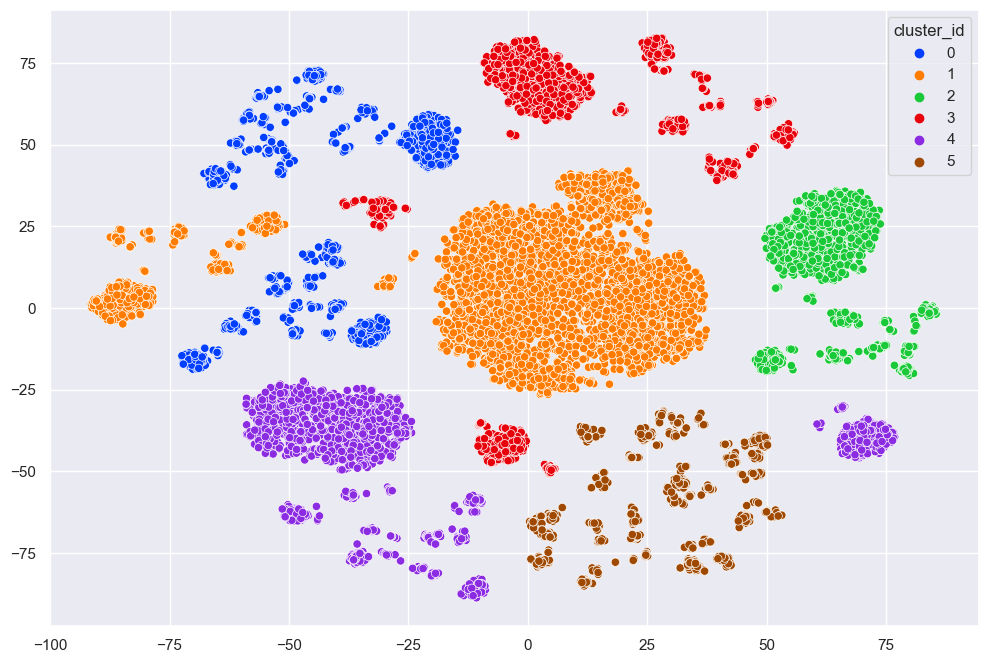

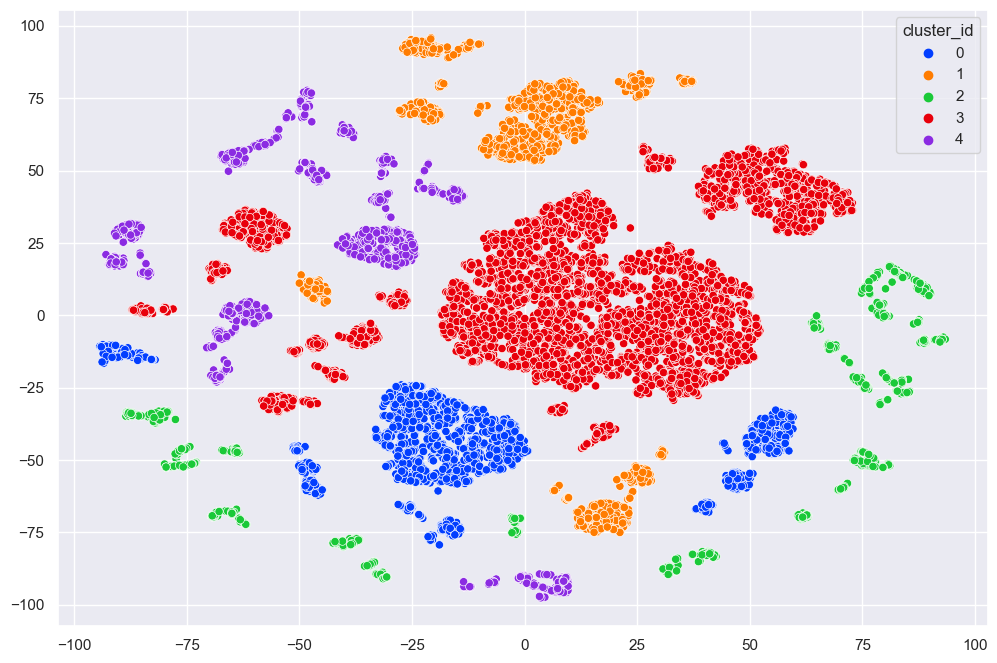

In [38]:
generate_tsne_scatter_plot(k_means_, True, 5)
generate_tsne_scatter_plot(k_means_selected, True, 6)
generate_tsne_scatter_plot(k_means_pca, True, 5)


### Hierarchical Clustering

#### Dendrogram

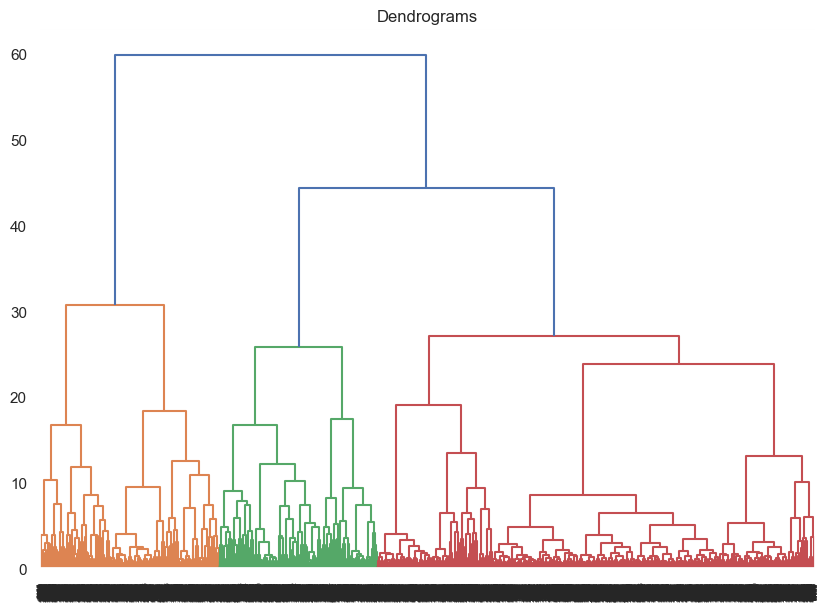

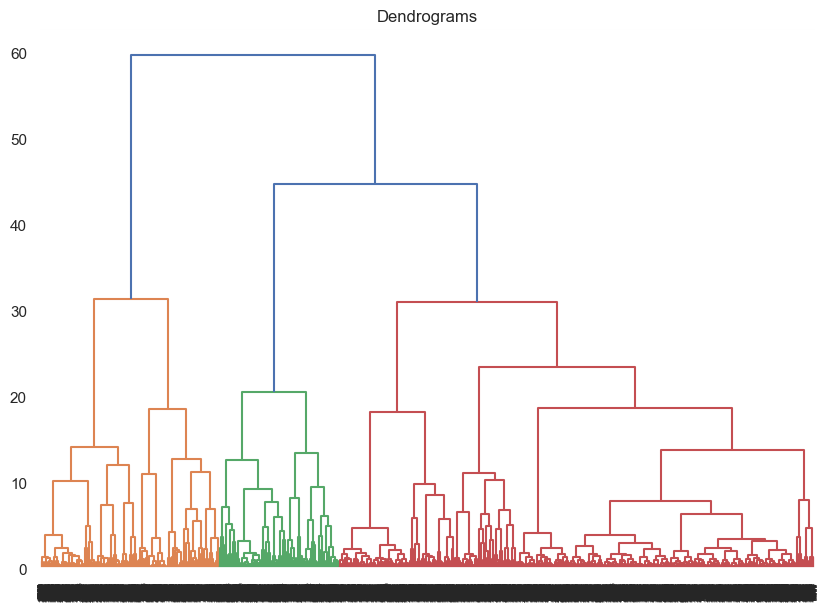

In [39]:
generate_dendrogram(scaled_selected_df, False)
generate_dendrogram(scaled_pca_df, False)


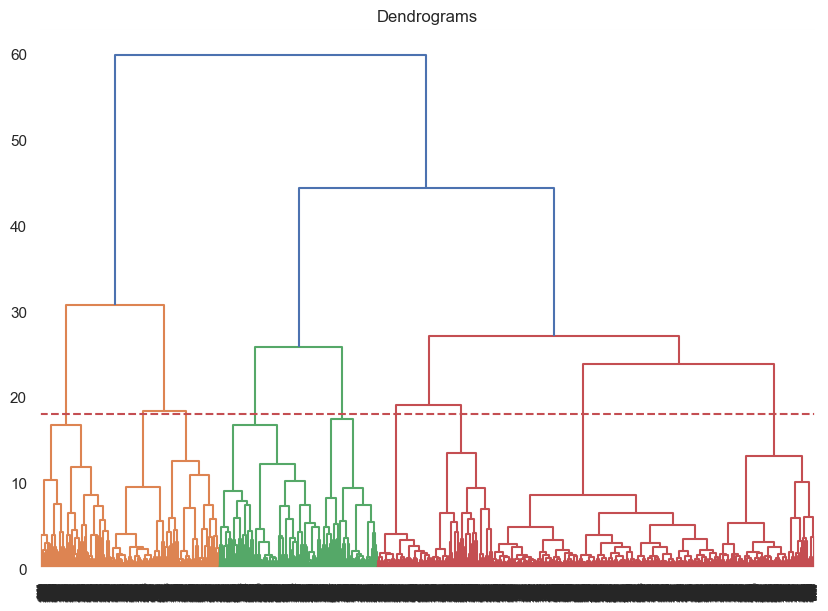

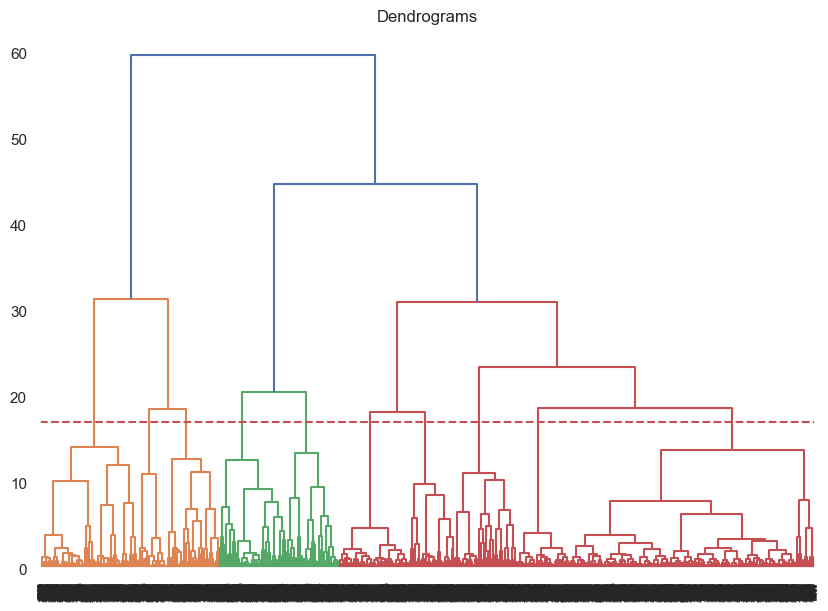

In [40]:
generate_dendrogram(scaled_selected_df, True, 18)
generate_dendrogram(scaled_pca_df, True, 17)

#### Clustering

In [41]:
# selected data 
hier_selected = generate_clusters(scaled_selected_df, 9, 'hier')
# PCA data
hier_pca = generate_clusters(scaled_pca_df, 10, 'hier')

------- hier -------
Silhouette Coefficient: 0.214
Davies-Bouldin Score: 1.691

------- hier -------
Silhouette Coefficient: 0.318
Davies-Bouldin Score: 1.332



#### Visualisation - before

In [42]:
# generate_tsne_scatter_plot(scaled_selected_df, False)
# generate_tsne_scatter_plot(scaled_pca_df, False)

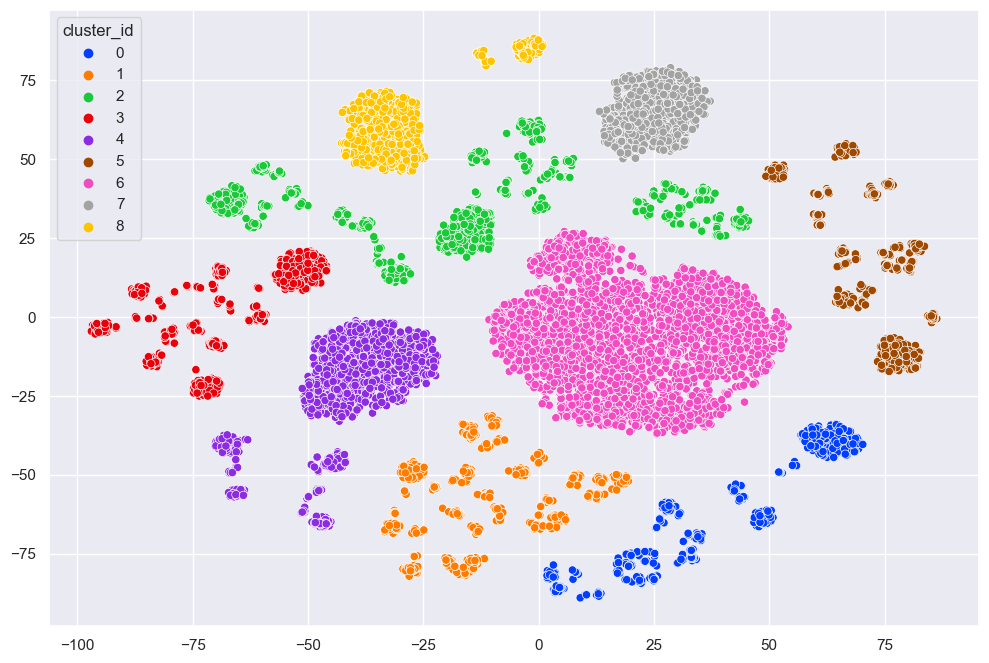

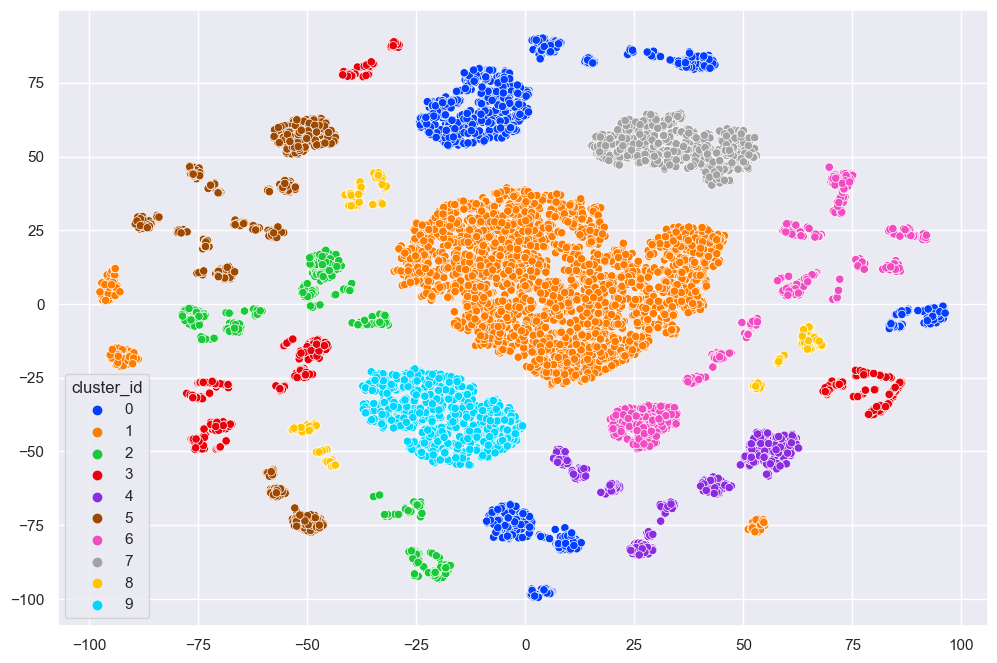

In [43]:
generate_tsne_scatter_plot(hier_selected, True, 9)
generate_tsne_scatter_plot(hier_pca, True, 10)

### GMM

#### BIC & AIC

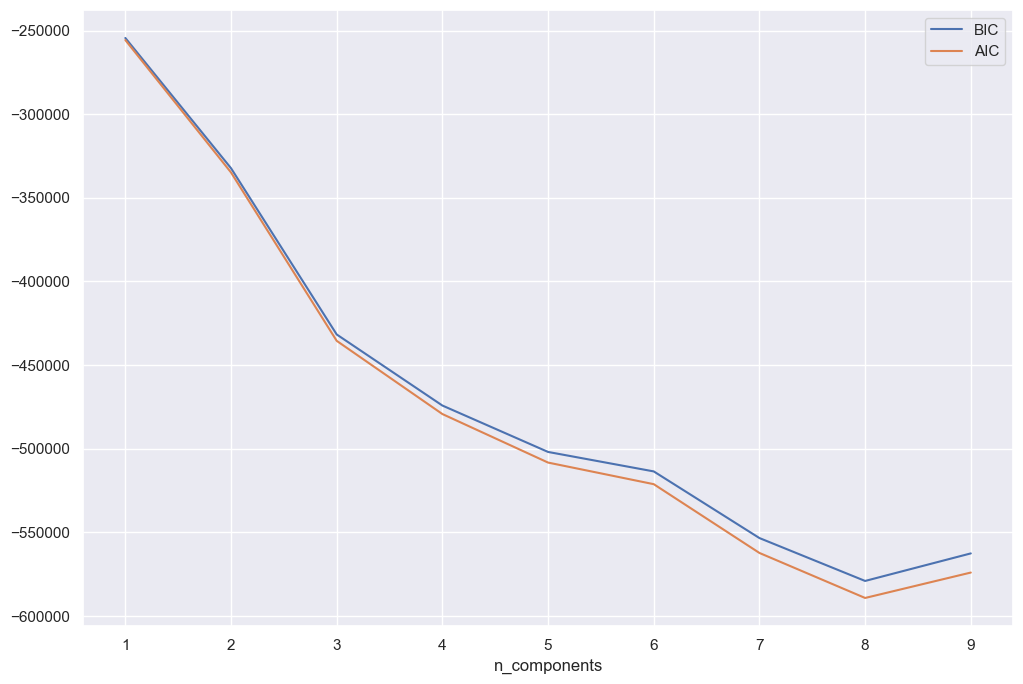

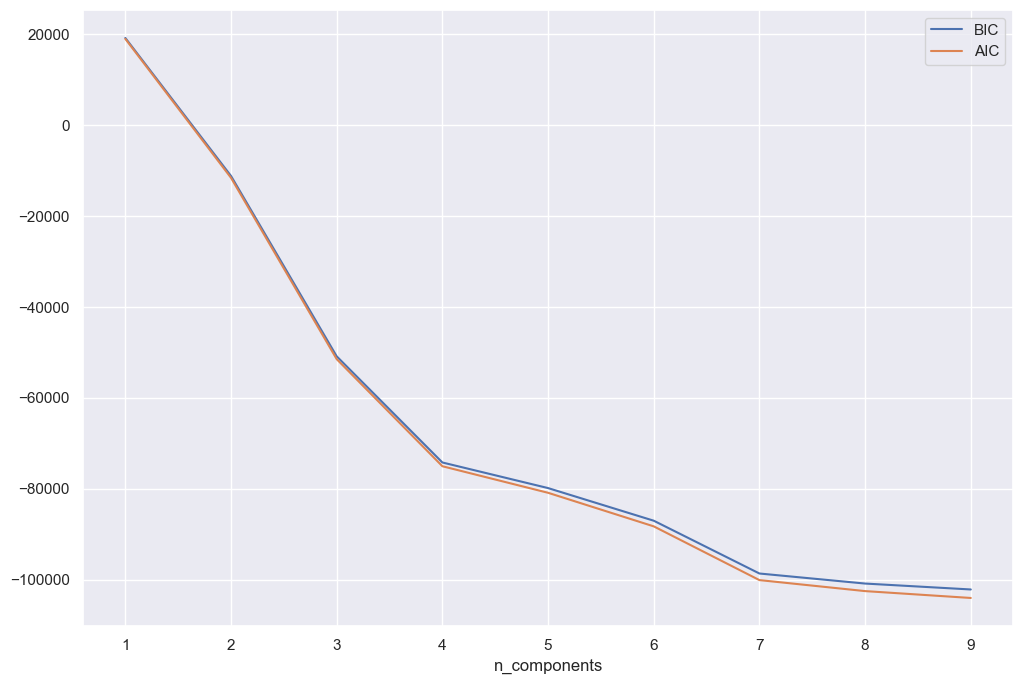

In [44]:
generate_bic(scaled_selected_df)
generate_bic(scaled_pca_df)


In [45]:
# all data
gmm_ = generate_clusters( scaled_df, k_, 'GMM')
# selected data 
gmm_selected = generate_clusters(scaled_selected_df, 9, 'GMM')
# PCA data
gmm_pca = generate_clusters(scaled_pca_df, 9, 'GMM')

------- GMM -------
Silhouette Coefficient: 0.142
Davies-Bouldin Score: 2.822

------- GMM -------
Silhouette Coefficient: 0.243
Davies-Bouldin Score: 1.723

------- GMM -------
Silhouette Coefficient: 0.342
Davies-Bouldin Score: 1.376



#### Visualisation

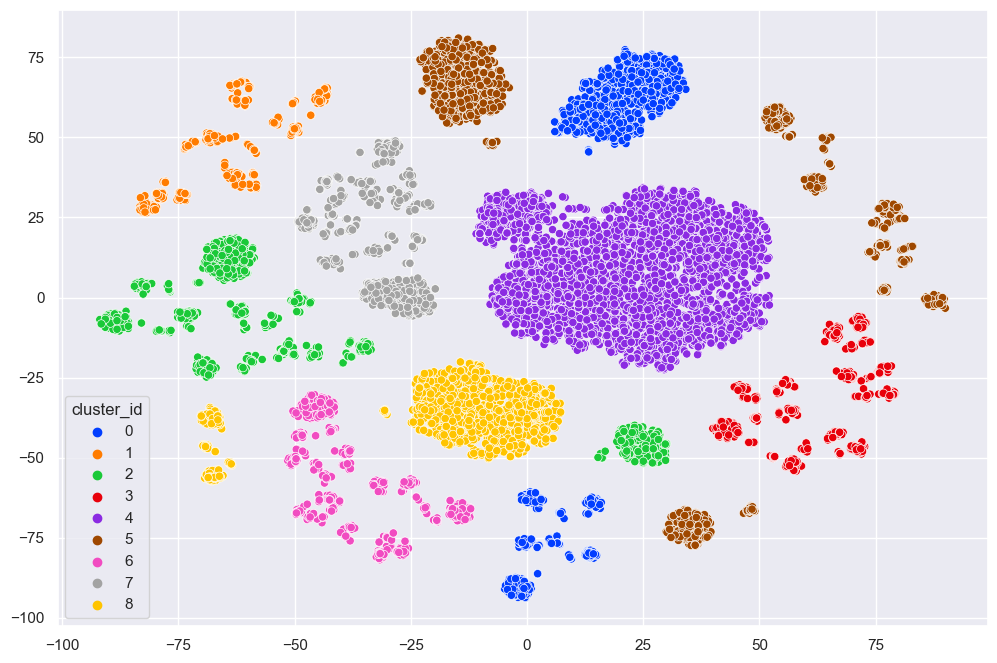

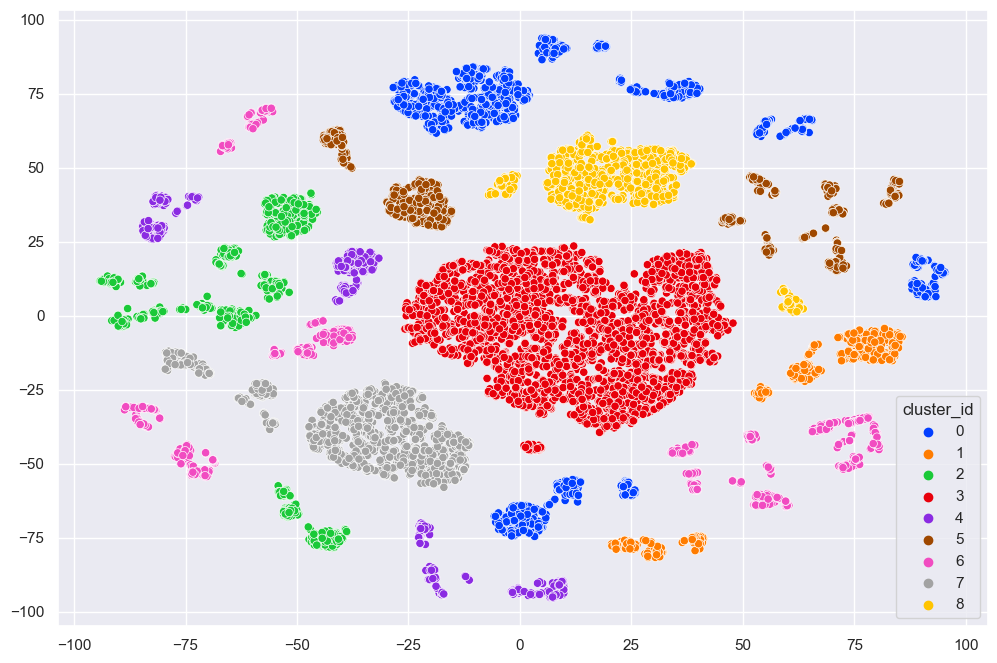

In [46]:
generate_tsne_scatter_plot(gmm_selected, True, 9)
generate_tsne_scatter_plot(gmm_pca, True, 9)

### BGM

In [47]:
# all data
bgm_ = generate_clusters(scaled_df, k_, 'BGM')
# selected data 
bgm_selected = generate_clusters(scaled_selected_df, 9, 'BGM')
# PCA data
bgm_pca = generate_clusters(scaled_pca_df, 9, 'BGM')

------- BGM -------
Silhouette Coefficient: 0.139
Davies-Bouldin Score: 2.763

------- BGM -------
Silhouette Coefficient: 0.228
Davies-Bouldin Score: 1.744

------- BGM -------
Silhouette Coefficient: 0.332
Davies-Bouldin Score: 1.358



#### Visualisation

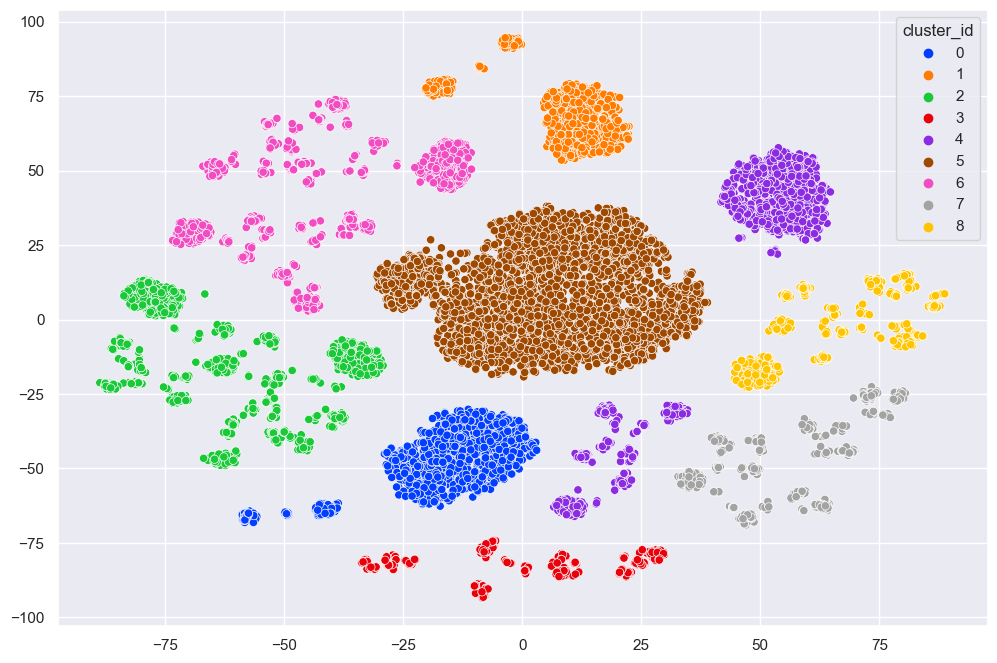

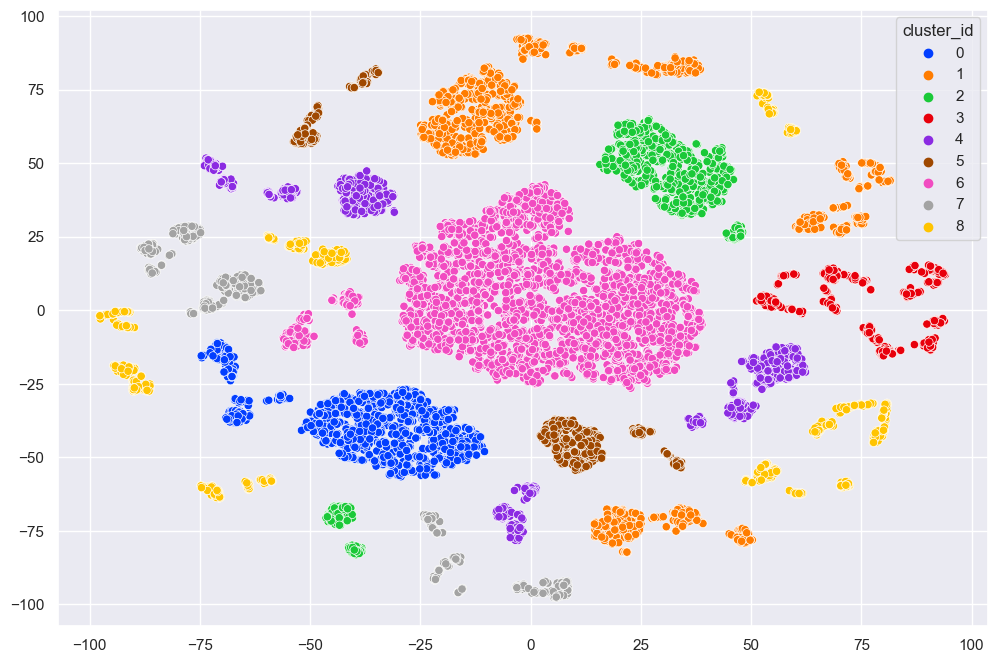

In [48]:
generate_tsne_scatter_plot(bgm_selected, True, 9)
generate_tsne_scatter_plot(bgm_pca, True, 9)

## Vaildation 

In [49]:
id_col = df['ref_PS']

In [50]:
# cluster data to csv
cluster_list = [k_means_, k_means_selected, k_means_pca,
                hier_selected, hier_pca,
                gmm_, gmm_selected, gmm_pca,
                bgm_, bgm_selected, bgm_pca
                ]

In [51]:
for item in cluster_list:
    item['ref_PS'] = id_col

In [68]:
# read in fraudulent_opticians dataset
target_df = pd.read_csv(fraudulent_opticians)

k_means_best, k_means_cluster, k_means_pct = fraud_table(k_means_pca, target_df)
k_means_best
print('######## K-means: Best cluster is #', k_means_cluster, 'with', round(k_means_pct,3), 'percent of proved frausters ########')

hier_best, hier_cluster, hier_pct = fraud_table(hier_pca, target_df)
hier_best
print('######## Hierarchical: Best cluster is #', hier_cluster, 'with', round(hier_pct,3), 'percent of proved frausters ########')

gmm_best, gmm_cluster, gmm_pct = fraud_table(gmm_pca, target_df)
gmm_best
print('######## GMM: Best cluster is #', gmm_cluster, 'with', round(gmm_pct,3), 'percent of proved frausters ########')

bgm_best, bgm_cluster, bgm_pct = fraud_table(bgm_pca, target_df)
bgm_best
print('######## BGM: Best cluster is #', bgm_cluster, 'with', round(bgm_pct,3), 'percent of proved frausters ########')


cluster_id  fraud  Count  in-group pct
0           0  False   2022      0.992636
1           0   True     15      0.007364
2           1  False   1723      0.994230
3           1   True     10      0.005770
4           2  False   1380      0.995671
5           2   True      6      0.004329
6           3  False   5691      0.991118
7           3   True     51      0.008882
8           4  False   1615      0.940047
9           4   True    103      0.059953

######## K-means: Best cluster is # 4 with 0.06 percent of proved frausters ########


cluster_id  fraud  Count  in-group pct
0            0  False   1607      0.998137
1            0   True      3      0.001863
2            1  False   3946      0.989220
3            1   True     43      0.010780
4            2  False    830      0.970760
5            2   True     25      0.029240
6            3  False    837      0.985866
7            3   True     12      0.014134
8            4  False    702      0.991525
9            4   True      6      0.008475
10           5  False   1007      0.993097
11           5   True      7      0.006903
12           6  False   1014      0.923497
13           6   True     84      0.076503
14           7  False    881      1.000000
15           8  False    461      1.000000
16           9  False   1146      0.995656
17           9   True      5      0.004344

######## Hierarchical: Best cluster is # 6 with 0.077 percent of proved frausters ########


cluster_id  fraud  Count  in-group pct
0            0  False   1743      0.998282
1            0   True      3      0.001718
2            1  False    638      0.990683
3            1   True      6      0.009317
4            2  False   1077      0.992627
5            2   True      8      0.007373
6            3  False   3678      0.988710
7            3   True     42      0.011290
8            4  False    730      0.970745
9            4   True     22      0.029255
10           5  False    893      0.915897
11           5   True     82      0.084103
12           6  False   1162      0.989779
13           6   True     12      0.010221
14           7  False   1430      0.994437
15           7   True      8      0.005563
16           8  False   1080      0.998152
17           8   True      2      0.001848

######## GMM: Best cluster is # 5 with 0.084 percent of proved frausters ########


cluster_id  fraud  Count  in-group pct
0            0  False   1435      0.993767
1            0   True      9      0.006233
2            1  False   1845      0.997837
3            1   True      4      0.002163
4            2  False   1104      0.998192
5            2   True      2      0.001808
6            3  False    617      0.982484
7            3   True     11      0.017516
8            4  False   1122      0.991166
9            4   True     10      0.008834
10           5  False    602      0.894502
11           5   True     71      0.105498
12           6  False   3916      0.988639
13           6   True     45      0.011361
14           7  False    730      0.970745
15           7   True     22      0.029255
16           8  False   1060      0.989729
17           8   True     11      0.010271

######## BGM: Best cluster is # 5 with 0.105 percent of proved frausters ########


## Best Result Analysis - K-means with PCA data

In [53]:
df_importance_pca = clusterting_feature_importance(k_means_pca, 'cluster_id')

# Cluster 3
df_cluster0_pca = df_importance_pca[3]
df_cluster0_pca = pd.DataFrame(df_cluster0_pca)
df_cluster0_pca = df_cluster0_pca.sort_values(by = 3, ascending = False)
top_cluster0_pca = df_cluster0_pca[:3]
top_cluster0_pca = top_cluster0_pca.rename(columns = {3:'Feature Importance in Cluster'})

# Cluster 4
df_cluster1_pca = df_importance_pca[4]
df_cluster1_pca = pd.DataFrame(df_cluster1_pca)
df_cluster1_pca = df_cluster1_pca.sort_values(by = 4, ascending = False)
top_cluster1_pca = df_cluster1_pca[:3]
top_cluster1_pca = top_cluster1_pca.rename(columns = {4:'Feature Importance in Cluster'})


<AxesSubplot:>

Text(0.5, 1.0, 'Top 3 Components of Cluster 1')

<AxesSubplot:>

Text(0.5, 1.0, 'Top 3 Components of Cluster 4')

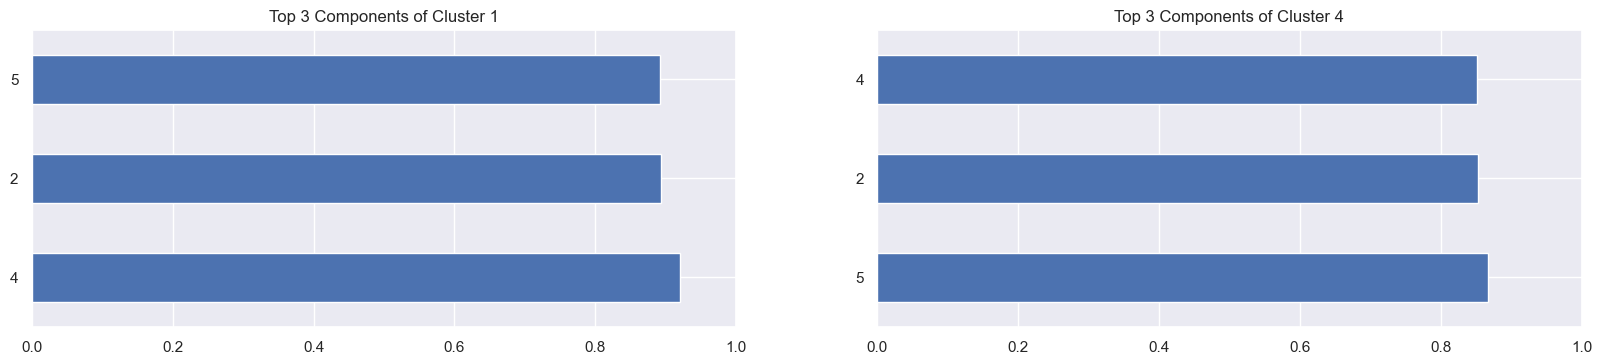

In [54]:
# select top 2 clusters which contain the most fraud ids

fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (20,3))

top_cluster0_pca.plot(ax = ax1, kind = 'barh', xlim = (0, 1))
ax1.set_title('Top 3 Components of Cluster 1')

top_cluster1_pca.plot(ax = ax2, kind = 'barh', xlim = (0, 1))
ax2.set_title('Top 3 Components of Cluster 4')


ax1.get_legend().remove()
ax2.get_legend().remove()
plt.subplots_adjust(top = 1.1)
plt.show()
plt.savefig('plots/best_kmeans_rules1.png', bbox_inches='tight')


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

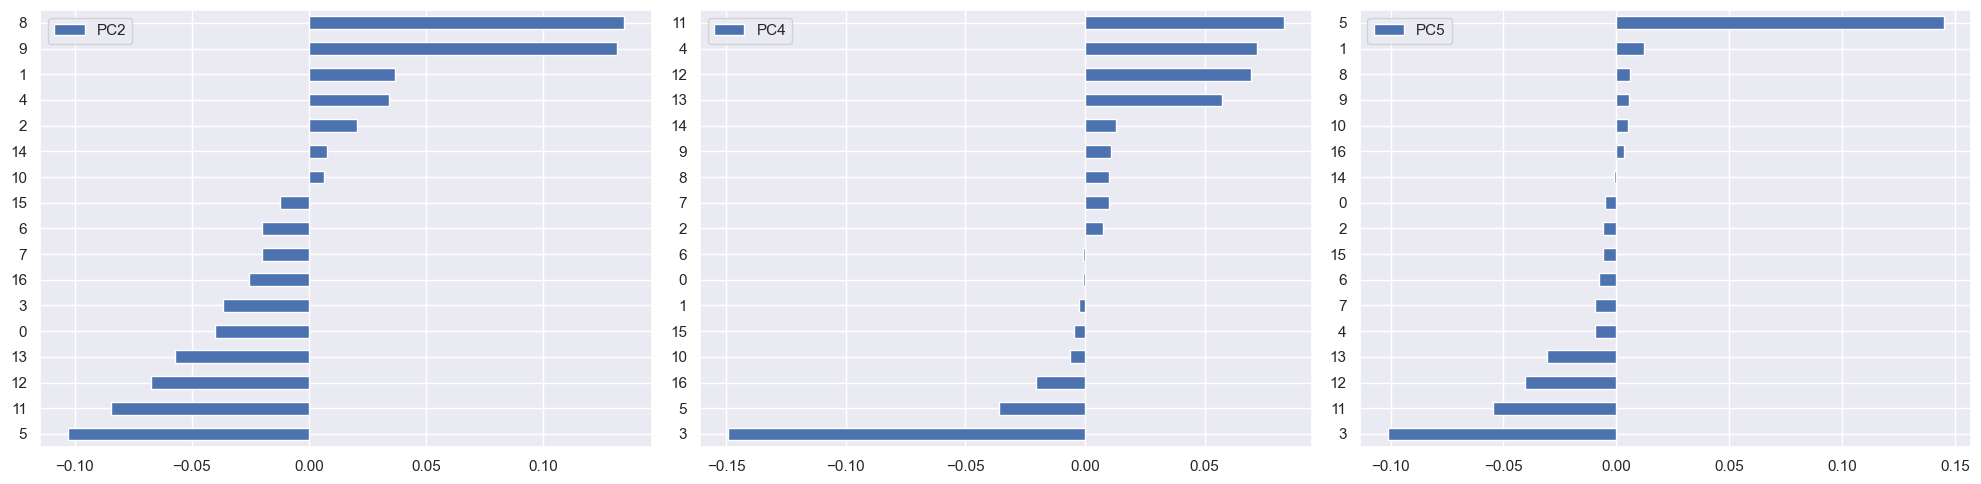

In [55]:
# find out the relationship between PCs and features

# PC2
df_pca_0 = pd.DataFrame(loading_matrix['PC2'])
df_pca_0.sort_values(by = 'PC2', inplace = True)

# # PC3
# df_pca_1 = pd.DataFrame(loading_matrix['PC3'])
# df_pca_1.sort_values(by = 'PC3', inplace = True)

# PC4
df_pca_2 = pd.DataFrame(loading_matrix['PC4'])
df_pca_2.sort_values(by = 'PC4', inplace = True)

# PC5
df_pca_3 = pd.DataFrame(loading_matrix['PC5'])
df_pca_3.sort_values(by = 'PC5', inplace = True)


fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (20,5) )
df_pca_0.plot(kind = 'barh', ax = ax1)
# df_pca_1.plot(kind = 'barh', ax = ax2)
df_pca_2.plot(kind = 'barh', ax = ax2)
df_pca_3.plot(kind = 'barh', ax = ax3)

plt.tight_layout()
plt.show()
# plt.savefig('plots/best_kmeans_rules2.png', bbox_inches='tight')


In [56]:
selected_df

ref_PS  dep_identique  dep_limit  dep_non_limit  PEC_ANN  \
0      8c47fdd7c69650b          96.23       1.89           1.89     3.77   
1      89bf4429f3ebda1         100.00       0.00           0.00    22.58   
2      5076215e2ee1797          95.45       4.55           0.00    13.64   
3      3a771e3f5cbc3b2          97.56       0.00           2.44     0.00   
4      ced6f62ac55fd34          50.00       0.00          50.00    25.00   
...                ...            ...        ...            ...      ...   
12611  c335633c0fbe713          75.00      25.00           0.00    14.47   
12612  72373e7fa1ab691          90.00      10.00           0.00     5.00   
12613  997171895d121ff          88.57       8.57           2.86    28.57   
12614  8759d1c2aa42bb8          93.33       6.67           0.00    25.00   
12615  ee3e25bff6e919f          87.72       1.75          10.53    28.07   

       PEC_FAC  PEC_REF  Prix_monture  Prix_equipement  \
0        62.26     3.77     82.264151       308.792453   
1        51.61     6.45    111.870968       362.580645   
2        68.18     0.00    220.454545       530.727273   
3        82.93     0.00    211.707317       517.512195   
4        75.00     0.00    201.250000       522.250000   
...        ...      ...           ...              ...   
12611    40.79    36.84    143.973684       586.184211   
12612    50.00     5.00    119.700000       564.100000   
12613    34.29    34.29    137.885714       376.942857   
12614    43.33    28.33    120.933333       500.700000   
12615    59.65     1.75    170.438596       397.912281   

       Pourcent_remise_monture  Pourcent_remise_total  cor_sphere_VG  \
0                     0.000000               0.000000      -0.301887   
1                    16.118800               7.927046       0.000000   
2                     0.000000               0.000000      -0.272727   
3                     0.000000               0.000000       0.000000   
4                     0.000000               0.000000      -0.500000   
...                        ...                    ...            ...   
12611                 0.813380               0.565657      -0.684211   
12612                20.927318              18.356674       0.000000   
12613                 0.000000               0.454787      -0.228571   
12614                 4.561742               2.819386      -1.066667   
12615                10.159547              11.882192      -0.035088   

       cor_cylindre_VG  cor_addition_VG  facteur_correction  age_moyen  \
0             0.056604         0.226415            1.056604  45.396226   
1             0.096774         0.193548            0.548387  49.096774   
2             0.227273         0.181818            2.318182  34.863636   
3             0.000000         0.048780            0.365854  31.829268   
4             0.000000         0.000000            1.000000  43.750000   
...                ...              ...                 ...        ...   
12611         0.526316         0.934211            6.657895  41.960526   
12612         0.000000         0.550000            2.600000  53.600000   
12613         0.542857         0.028571            3.257143  32.857143   
12614         0.250000         0.933333            5.900000  48.016667   
12615         0.105263         0.228070            1.842105  36.771930   

       nb_prescripteurs  nb_PEC_par_prescripteurs  
0                    24                      2.21  
1                    11                      2.82  
2                    11                      2.00  
3                     8                      5.12  
4                     3                      1.33  
...                 ...                       ...  
12611                18                      4.22  
12612                 9                      2.22  
12613                11                      3.18  
12614                 6                     10.00  
12615                28                      2.04  

[12616 rows x 18 columns]

## Save Results

In [57]:
df_ = df.drop(['Prix_verres', 'PEC_CRE', 'cor_sphere_VD', 'cor_cylindre_VD', 'cor_addition_VD', 'Pourcent_remise_verre', 'taux_non_ventes', 'PEC_ACC', 'nb_lignes_PEC'], axis = 1)

selected_df['cluster_id'] = k_means_pca['cluster_id']
selected_df['predicted_label'] = np.where(selected_df['cluster_id'] == 1, 1, 0)


# scatter_df = df_compare.merge(df_, how = 'left', left_on='ref_PS', right_on='ref_PS')
selected_df.groupby('predicted_label').count()
selected_df.to_csv('results/labeled_kmeans.csv', index = False)

ref_PS  dep_identique  dep_limit  dep_non_limit  PEC_ANN  \
predicted_label                                                             
0                 10883          10883      10883          10883    10883   
1                  1733           1733       1733           1733     1733   

                 PEC_FAC  PEC_REF  Prix_monture  Prix_equipement  \
predicted_label                                                    
0                  10883    10883         10883            10883   
1                   1733     1733          1733             1733   

                 Pourcent_remise_monture  Pourcent_remise_total  \
predicted_label                                                   
0                                  10883                  10883   
1                                   1733                   1733   

                 cor_sphere_VG  cor_cylindre_VG  cor_addition_VG  \
predicted_label                                                    
0                        10883            10883            10883   
1                         1733             1733             1733   

                 facteur_correction  age_moyen  nb_prescripteurs  \
predicted_label                                                    
0                             10883      10883             10883   
1                              1733       1733              1733   

                 nb_PEC_par_prescripteurs  cluster_id  
predicted_label                                        
0                                   10883       10883  
1                                    1733        1733

In [58]:
# # save cluster data to csv
# k_means_.to_csv('results/clusters/k_means.csv', index = False)
# k_means_selected.to_csv('results/clusters/k_means_selected.csv', index = False)
# k_means_pca.to_csv('results/clusters/k_means_pca.csv', index = False)

In [59]:
# # save cluster data to csv
# # hier_.to_csv('results/clusters/hier.csv', index = False)
# hier_selected.to_csv('results/clusters/hier_selected.csv', index = False)
# hier_pca.to_csv('results/clusters/hier_pca.csv', index = False)

In [60]:
# # save cluster data to csv
# gmm_.to_csv('results/clusters/gmm.csv', index = False)
# gmm_selected.to_csv('results/clusters/gmm_selected.csv', index = False)
# gmm_pca.to_csv('results/clusters/gmm_pca.csv', index = False)

In [61]:
# # save cluster data to csv
# bgm_.to_csv('results/clusters/bgm.csv', index = False)
# bgm_selected.to_csv('results/clusters/bgm_selected.csv', index = False)
# bgm_pca.to_csv('results/clusters/bgm_pca.csv', index = False)

In [62]:
# # get the end time
# et = time.time()

# # get the execution time
# elapsed_time = et - st
# print('Execution time:', round(elapsed_time, 3), 'seconds')